In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import Image

In [2]:
def month_string_to_number(string):
    """ month_string_to_number takes a month and turns it into the 
    corresponding number
    args:
        :string - each item is a string

    returns:
        :(out) - the equivalent of the month's number
    """
    m = {
        'jan': 1,
        'feb': 2,
        'mar': 3,
        'apr':4,
         'may':5,
         'jun':6,
         'jul':7,
         'aug':8,
         'sep':9,
         'oct':10,
         'nov':11,
         'dec':12
        }
    s = string.strip()[:3].lower()

    try:
        out = m[s]
        return out
    except:
        raise ValueError('Not a month')



In [3]:
path = '/Users/afugere/Desktop/UVM Masters/GraduateSemester2/STAT330/FinalProject/'
path2 = '/Users/abigailhotaling/Documents/STAT_330_Project/Data/'

In [5]:
data = pd.read_csv(path2+ 'Electricity_Residential_Price_New_England.csv')

In [6]:
#data.columns = ['Date', 'Electricity Residential Price: New England cents per kilowatthour']
data.columns = ['Date', 'Electricity Price']
# I also changed the column name for now, just to be a little bit shorter 
dates = []
months = []
years = []
for entry in data['Date']:
    dates.append(entry.replace('-', ' '))
    data['Month and Year'] = pd.Series(dates)
    months.append(month_string_to_number(str(entry[0:-3])))
    years.append(entry[-2:])
    data['Month'] = pd.Series(months)
    data['Year'] = pd.Series(years)
    

In [7]:
updated_years = []
for y in data['Year']:
    if int(y) > 19:
        updated_years.append('19'+y)
    else:
        updated_years.append('20'+y)
    data['Year'] = pd.Series(updated_years)

In [8]:
data['Day'] = [1]*len(data)

In [9]:
data['Datetime'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
data.iloc[:] = data.iloc[::-1].values

In [10]:
data.head()

,Date,Electricity Price,Month and Year,Month,Year,Day,Datetime
0,Dec-96,12.30,Dec 96,12,1996,1,1996-12-01
1,Jan-97,11.81,Jan 97,1,1997,1,1997-01-01
2,Feb-97,11.73,Feb 97,2,1997,1,1997-02-01
3,Mar-97,12.07,Mar 97,3,1997,1,1997-03-01
4,Apr-97,11.54,Apr 97,4,1997,1,1997-04-01


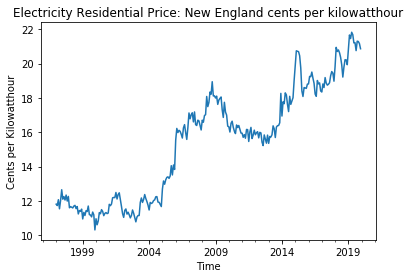

In [10]:
ax = data.plot(x = 'Datetime', y = 'Electricity Price', 
               title = 'Electricity Residential Price: New England cents per kilowatthour', legend = False)
ax.set_xlabel('Time')
ax.set_ylabel('Cents per Kilowatthour')
ax.format_xdata = mdates.DateFormatter('%Y-%m')

## Seasonal Subseries Plots

In [11]:
groups = data.groupby('Month')
months = pd.concat([pd.DataFrame({name:group['Electricity Price'].values}) for name, group in groups],
                   ignore_index=True, axis=1)
     
months.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

Text(0.5,1,'Seasonality Subplot')

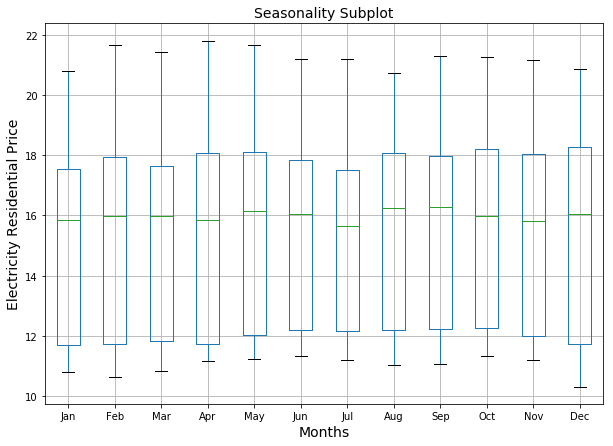

In [12]:
ax = months.boxplot(figsize = (10, 7))
ax.set_xlabel("Months", fontsize=14)
ax.set_ylabel('Electricity Residential Price', fontsize=14)
ax.set_title('Seasonality Subplot', fontsize=14)

There doesn't appear to be a large seasonal trend, that I can see at least. Let me know what you think. 

## Autoregressive Models

As some preliminary work lets fit some AR models. 
Some things to check:
    - Autocorrelation
    - Lag
    - Residuals
    
I completed this section following this link: https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/

### Lag Plot

There is a clear linear relationship between the previous month and the next month. 

/Users/afugere/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.lag_plot' is deprecated, import 'pandas.plotting.lag_plot' instead.
  


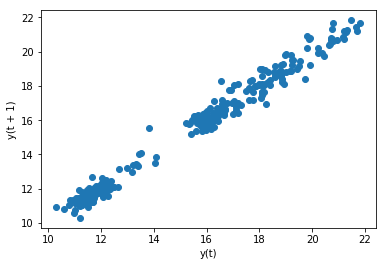

In [12]:
from pandas.tools.plotting import lag_plot
lag_plot(data['Electricity Price'])

In [13]:
dataframe = pd.concat([data['Electricity Price'].shift(1), data['Electricity Price']], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.991059
t+1  0.991059  1.000000


The correlation is very high, 0.99

/Users/afugere/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  


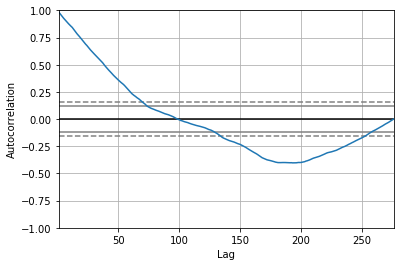

In [14]:
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(data['Electricity Price'])


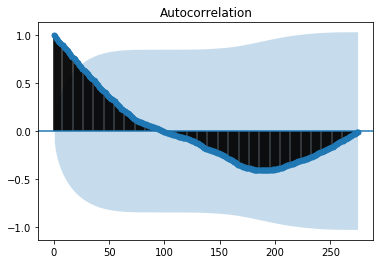

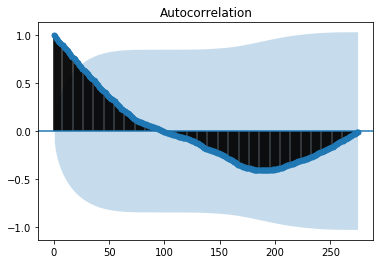

In [15]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data['Electricity Price'])


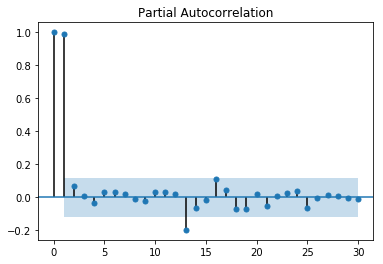

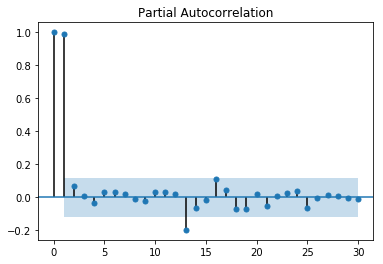

In [16]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data['Electricity Price'], lags=30)


### Percistance Model
The simplest model that we could use to make predictions would be to persist the last observation. We can call this a persistence model and it provides a baseline of performance for the problem that we can use for comparison with an autoregression model.

Right now we will try to predict the last 6 months of the data set. The predictions are made using a walk-forward validation model so that we can persist the most recent observations for the next month. This means that we are not making a 6-month forecast, but 6 1-month forecasts.

Test MSE: 0.103


Text(0,0.5,'Electricity Price')

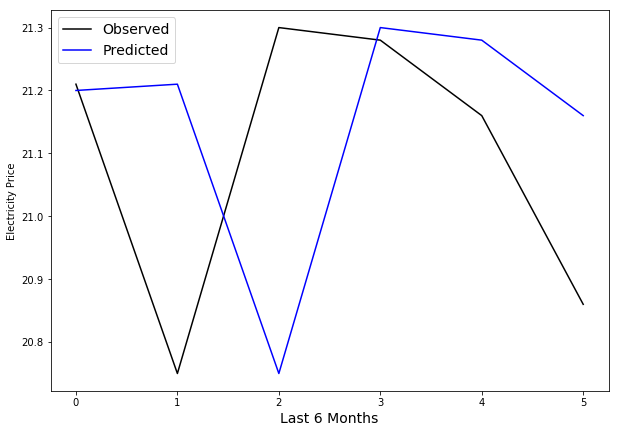

In [17]:
from sklearn.metrics import mean_squared_error
# create lagged dataset
values = data['Electricity Price']
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-6], X[len(X)-6:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

# persistence model
def model_persistence(x):
    return x

# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)

# plot predictions vs expected
fig, ax = plt.subplots(figsize = (10,7))
ax.plot(test_y, color = 'black', label = 'Observed')
ax.plot(predictions, color = 'blue', label = 'Predicted')
ax.legend(loc='best', fontsize = 14)
ax.set_xlabel('Last 6 Months', fontsize=14)
ax.set_ylabel('Electricity Price')

### Auto Regressive Model

An autoregression model is a linear regression model that uses lagged variables as input variables.

We could calculate the linear regression model manually using the LinearRegession class in scikit-learn and manually specify the lag input variables to use.

Alternately, the statsmodels library provides an autoregression model that automatically selects an appropriate lag value using statistical tests and trains a linear regression model. It is provided in the AR class.

We can use this model by first creating the model AR() and then calling fit() to train it on our dataset. This returns an ARResult object.

Once fit, we can use the model to make a prediction by calling the predict() function for a number of observations in the future. This creates 1 6-month forecast, which is different from the persistence example above.



Lag: 15
Coefficients: [ 0.12739859  0.79473107  0.16341501  0.03249565  0.03360748 -0.07274447
 -0.02324865  0.01369457  0.01328007  0.02074149 -0.04812912  0.17849463
  0.2417068  -0.22728056 -0.09567    -0.03115682]
predicted=20.894737, expected=21.210000
predicted=20.622202, expected=20.750000
predicted=20.761528, expected=21.300000
predicted=20.895922, expected=21.280000
predicted=20.839616, expected=21.160000
predicted=20.833489, expected=20.860000
Test MSE: 0.109


Text(0,0.5,'Electricity Price')

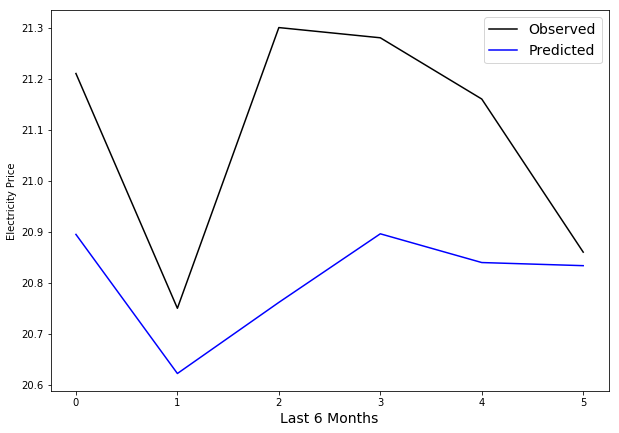

In [18]:
from statsmodels.tsa.ar_model import AR
X = data['Electricity Price'].values
train, test = X[1:len(X)-6], X[len(X)-6:]
# train autoregression
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# plot results
fig, ax = plt.subplots(figsize = (10,7))
ax.plot(test, color = 'black', label = 'Observed')
ax.plot(predictions, color = 'blue', label = 'Predicted')
ax.legend(loc='best', fontsize = 14)
ax.set_xlabel('Last 6 Months', fontsize=14)
ax.set_ylabel('Electricity Price')

predicted=20.894737, expected=21.210000
predicted=20.872751, expected=20.750000
predicted=20.914612, expected=21.300000
predicted=21.354991, expected=21.280000
predicted=21.247597, expected=21.160000
predicted=21.149732, expected=20.860000
Test MSE: 0.060


Text(0,0.5,'Electricity Price')

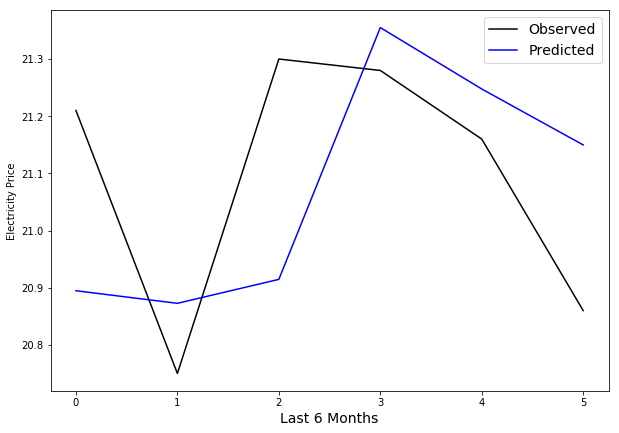

In [19]:
# split dataset
X = data['Electricity Price'].values
train, test = X[1:len(X)-6], X[len(X)-6:]
# train autoregression
model = AR(train)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot results
fig, ax = plt.subplots(figsize = (10,7))
ax.plot(test, color = 'black', label = 'Observed')
ax.plot(predictions, color = 'blue', label = 'Predicted')
ax.legend(loc='best', fontsize = 14)
ax.set_xlabel('Last 6 Months', fontsize=14)
ax.set_ylabel('Electricity Price')

Lag: 15
Coefficients: [ 0.2107562   0.76039949  0.20227198  0.05483878  0.04503567 -0.13298225
 -0.0091638  -0.0209921   0.0544996   0.04141705 -0.06007357  0.19413268
  0.19282747 -0.14867545 -0.09478804 -0.09142455]
Test MSE: 3.771


Text(0,0.5,'Electricity Price')

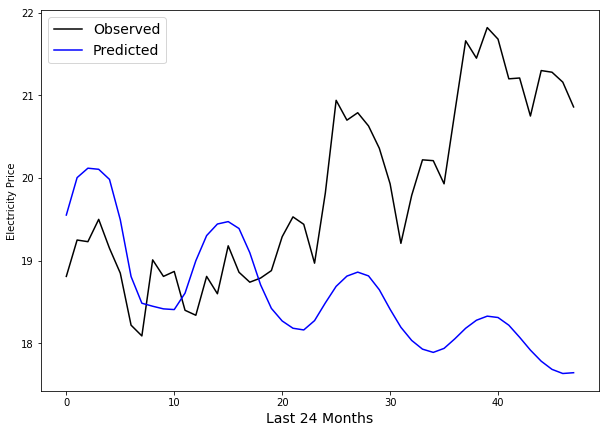

In [20]:
from statsmodels.tsa.ar_model import AR
X = data['Electricity Price'].values
train, test = X[1:len(X)-48], X[len(X)-48:]
# train autoregression
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
#for i in range(len(predictions)):
    #print('predicted=%f, expected=%f' % (predictions[i], test[i]))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# plot results
fig, ax = plt.subplots(figsize = (10,7))
ax.plot(test, color = 'black', label = 'Observed')
ax.plot(predictions, color = 'blue', label = 'Predicted')
ax.legend(loc='best', fontsize = 14)
ax.set_xlabel('Last 24 Months', fontsize=14)
ax.set_ylabel('Electricity Price')

Test MSE: 0.190


Text(0,0.5,'Electricity Price')

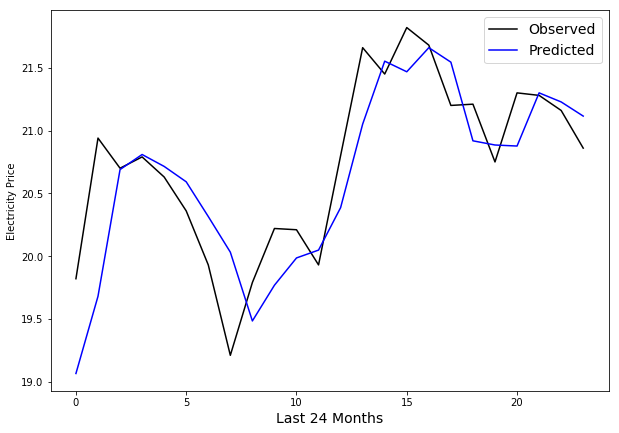

In [21]:
# split dataset
X = data['Electricity Price'].values
train, test = X[1:len(X)-24], X[len(X)-24:]
# train autoregression
model = AR(train)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot results
fig, ax = plt.subplots(figsize = (10,7))
ax.plot(test, color = 'black', label = 'Observed')
ax.plot(predictions, color = 'blue', label = 'Predicted')
ax.legend(loc='best', fontsize = 14)
ax.set_xlabel('Last 24 Months', fontsize=14)
ax.set_ylabel('Electricity Price')

### Moving Average Model 
https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/

Test MSE: 0.245


Text(0,0.5,'Electricity Price')

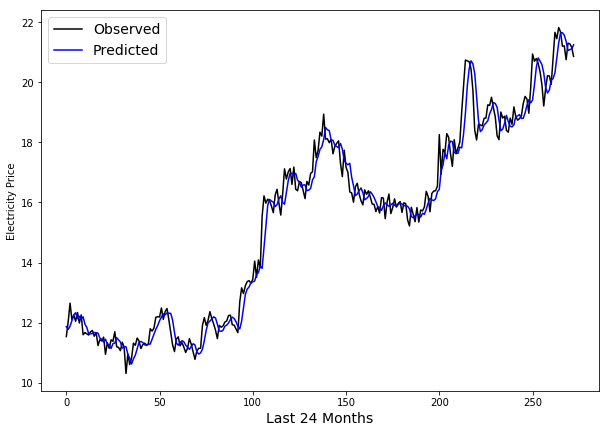

In [22]:
# split dataset
X = data['Electricity Price'].values
window = 3
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()
# walk forward over time steps in test
for t in range(len(test)):
    length = len(history)
    yhat = np.mean([history[i] for i in range(length-window,length)])
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
fig, ax = plt.subplots(figsize = (10,7))
ax.plot(test, color = 'black', label = 'Observed')
ax.plot(predictions, color = 'blue', label = 'Predicted')
ax.legend(loc='best', fontsize = 14)
#ax.set_xlim((50,100))
ax.set_xlabel('Last 24 Months', fontsize=14)
ax.set_ylabel('Electricity Price')

## Stationarity 

 A stationary series is one in which the properties – mean, variance and covariance, do not vary with time.
 
 Stationarity:
    https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/
  

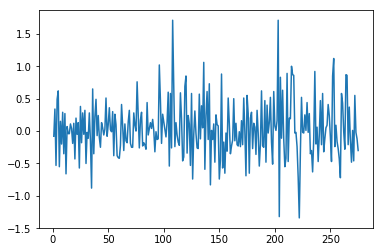

In [23]:
difference = data['Electricity Price'] - data['Electricity Price'].shift(1)
difference.dropna(inplace=True)
plt.plot(difference) # there is nonconstant variance --> needs a transformation?

In [24]:
price_log = np.log(data['Electricity Price'])
difference_log = price_log - price_log.shift(1)
difference_log.dropna(inplace=True)


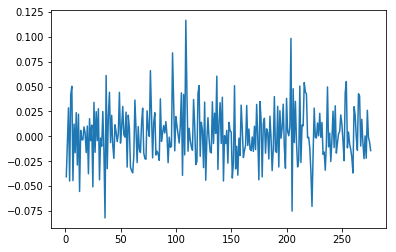

In [44]:
plt.plot(difference_log) # log transformation helps the variance a little (maybe hard to tell, need to do a test )

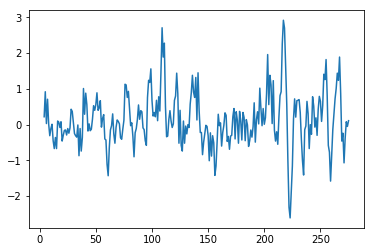

In [25]:
# seasonal differencing
n=4
seasonal_difference = data['Electricity Price'] - data['Electricity Price'].shift(n)
seasonal_difference.dropna(inplace=True)
plt.plot(seasonal_difference)

#### ADF (Augmented Dickey Fuller) Test

The Dickey Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test are:

Null Hypothesis: The series has a unit root (value of a =1)

Alternate Hypothesis: The series has no unit root.



In [26]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
adf_test(data['Electricity Price'])
# we can conclude that the raw data is unstationary. As we expected!! 

Results of Dickey-Fuller Test:
Test Statistic                  -0.512368
p-value                          0.889580
#Lags Used                      15.000000
Number of Observations Used    260.000000
Critical Value (1%)             -3.455754
Critical Value (5%)             -2.872721
Critical Value (10%)            -2.572728
dtype: float64


In [27]:
# perform the test on the differenced data
print('Differenced Data\n')
adf_test(difference)
print('\n')
print('Transformed Differenced Data\n')
adf_test(difference_log)
print('\n')
print('Seasonal Differenced Data\n')
adf_test(seasonal_difference)


Differenced Data

Results of Dickey-Fuller Test:
Test Statistic                  -3.587519
p-value                          0.006004
#Lags Used                      14.000000
Number of Observations Used    260.000000
Critical Value (1%)             -3.455754
Critical Value (5%)             -2.872721
Critical Value (10%)            -2.572728
dtype: float64


Transformed Differenced Data

Results of Dickey-Fuller Test:
Test Statistic                  -3.749616
p-value                          0.003467
#Lags Used                      15.000000
Number of Observations Used    259.000000
Critical Value (1%)             -3.455853
Critical Value (5%)             -2.872765
Critical Value (10%)            -2.572752
dtype: float64


Seasonal Differenced Data

Results of Dickey-Fuller Test:
Test Statistic                  -3.822189
p-value                          0.002688
#Lags Used                      11.000000
Number of Observations Used    260.000000
Critical Value (1%)             -3.455754


## ARIMA

Good References: 

    Modeling ARIMA:
    https://onlinecourses.science.psu.edu/stat510/node/64/
    
    Python Examples:
    https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
    
So far the best model is ARIMA with AR(1), difference 1 and no MA 

In [11]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

In [12]:
#order : iterable
    #The (p,d,q) order of the model for the number of AR parameters,
    #differences, and MA parameters to use.

                              ARMA Model Results                              
Dep. Variable:      Electricity Price   No. Observations:                  277
Model:                     ARMA(2, 0)   Log Likelihood                -160.896
Method:                       css-mle   S.D. of innovations              0.429
Date:                Fri, 30 Nov 2018   AIC                            329.792
Time:                        13:02:33   BIC                            344.288
Sample:                             0   HQIC                           335.608
                                                                              
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      16.0993      2.925      5.505      0.000      10.367      21.831
ar.L1.Electricity Price     0.8548      0.060     14.354      0.000       0.738       0.972


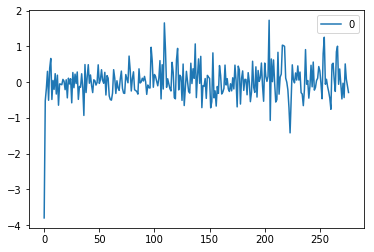

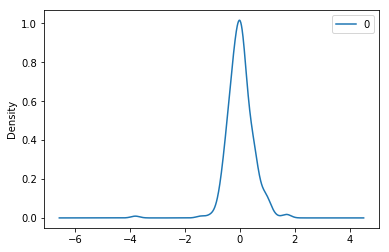

NameError: name 'autocorrelation_plot' is not defined

In [13]:
# fit model AR(1)
model = ARIMA(data['Electricity Price'], order=(2,0,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
autocorrelation_plot(residuals)
test = acorr_ljungbox(residuals)
fig, ax = plt.subplots()
ax.plot(test[1])
print(residuals.describe())

                              ARIMA Model Results                              
Dep. Variable:     D.Electricity Price   No. Observations:                  275
Model:                  ARIMA(1, 1, 0)   Log Likelihood                -156.571
Method:                        css-mle   S.D. of innovations              0.428
Date:                 Wed, 14 Nov 2018   AIC                            319.141
Time:                         11:10:11   BIC                            329.992
Sample:                              1   HQIC                           323.496
                                                                               
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.0331      0.022      1.478      0.141      -0.011       0.077
ar.L1.D.Electricity Price    -0.1509      0.060     -2.534      0.012      -0.

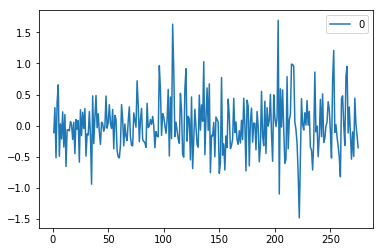

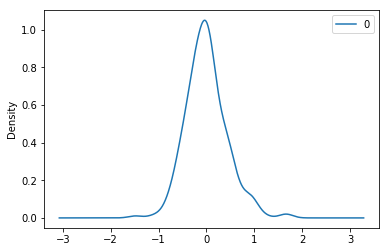

                0
count  275.000000
mean    -0.000062
std      0.428353
min     -1.485273
25%     -0.277458
50%     -0.019827
75%      0.226414
max      1.696026


/Users/afugere/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  # This is added back by InteractiveShellApp.init_path()


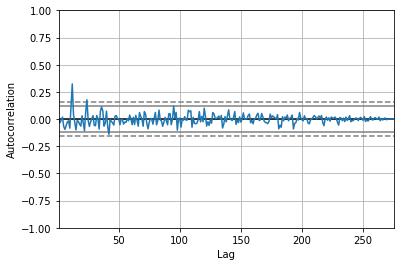

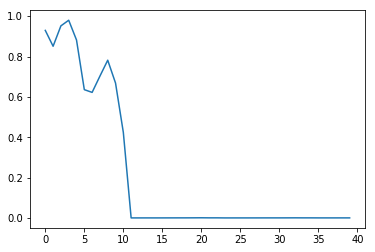

In [30]:
# fit model AR(1), difference 1
model = ARIMA(data['Electricity Price'], order=(1,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
autocorrelation_plot(residuals)
test = acorr_ljungbox(residuals)
fig, ax = plt.subplots()
ax.plot(test[1])
print(residuals.describe())

In [31]:
test[1]

array([9.29368238e-01, 8.50787308e-01, 9.51831292e-01, 9.79688720e-01,
       8.81817420e-01, 6.35702713e-01, 6.22125731e-01, 7.02764097e-01,
       7.81613390e-01, 6.68388668e-01, 4.23536015e-01, 3.98529560e-05,
       6.33838242e-05, 1.11614491e-04, 7.13541230e-05, 1.26966177e-04,
       2.14096191e-04, 2.93058326e-04, 3.22970573e-04, 4.87044751e-04,
       7.13383705e-04, 3.80623002e-04, 4.15376814e-04, 3.12971595e-05,
       5.15847579e-05, 5.39522578e-05, 8.16408900e-05, 1.29455962e-04,
       1.83967444e-04, 2.07322431e-04, 2.25279093e-04, 3.09316782e-04,
       4.60700215e-04, 3.22435959e-04, 3.13249944e-04, 1.54590906e-04,
       1.38895594e-04, 1.41615336e-04, 1.84355925e-04, 1.68807446e-04])

                              ARIMA Model Results                              
Dep. Variable:     D.Electricity Price   No. Observations:                  275
Model:                  ARIMA(2, 1, 0)   Log Likelihood                -156.432
Method:                        css-mle   S.D. of innovations              0.427
Date:                 Wed, 14 Nov 2018   AIC                            320.865
Time:                         11:10:20   BIC                            335.332
Sample:                              1   HQIC                           326.671
                                                                               
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.0332      0.022      1.526      0.128      -0.009       0.076
ar.L1.D.Electricity Price    -0.1557      0.060     -2.585      0.010      -0.

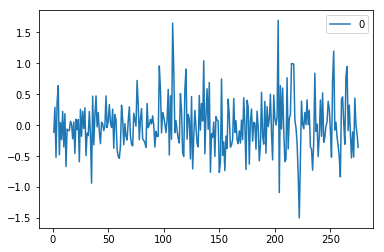

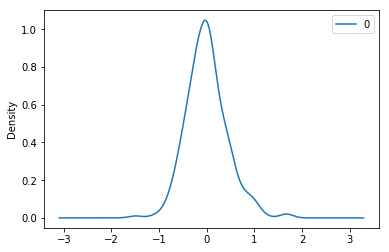

                0
count  275.000000
mean    -0.000040
std      0.428136
min     -1.497541
25%     -0.280205
50%     -0.022267
75%      0.225553
max      1.695872


In [32]:
# fit model AR(2), difference 1, MA 0
model = ARIMA(data['Electricity Price'], order=(2,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

## Ideas for Bayesian Models

#1) 

-Start by comparing to frequentist simple linear regression

-Kalman Filter (smoothing and de-noising of time series, forecasting might not be the best with this technique, but de-noising works!)

Example(s): couldn't find a good example yet

-Gibbs Sampling

Example(s): http://www.chadfulton.com/fulton_statsmodels_2017/sections/5-posterior_simulation.html

-Metropolis-Hastings

Example(s): https://wiseodd.github.io/techblog/2015/10/17/metropolis-hastings/ , http://sdsawtelle.github.io/blog/output/mcmc-in-python-with-pymc.html , http://people.duke.edu/~ccc14/sta-663-2016/16A_MCMC.html

Source: https://www.uio.no/studier/emner/matnat/ibv/BIO4040/h03/undervisningsmateriale/Lectures/lecture10.pdf


#2) THIS EXAMPLE USES DATA FOR FORCASTING ELECTRIC USE
Compare the Lognormal distribution for the likelihood with a noninformative prior (Bayesian) to the ARIMA model (frequentist)

--It tells us for this example that ARIMA models are better for long series while Bayesian forecases outperform the for short series. Bayesian is more proficient if only given minimal prior data, and can deal with the presence of cycles and trends.

--One major pitfall is that these models cannot be used if there are negative values in the series.

Source: http://allman.rhon.itam.mx/~mendoza/Foresight.pdf

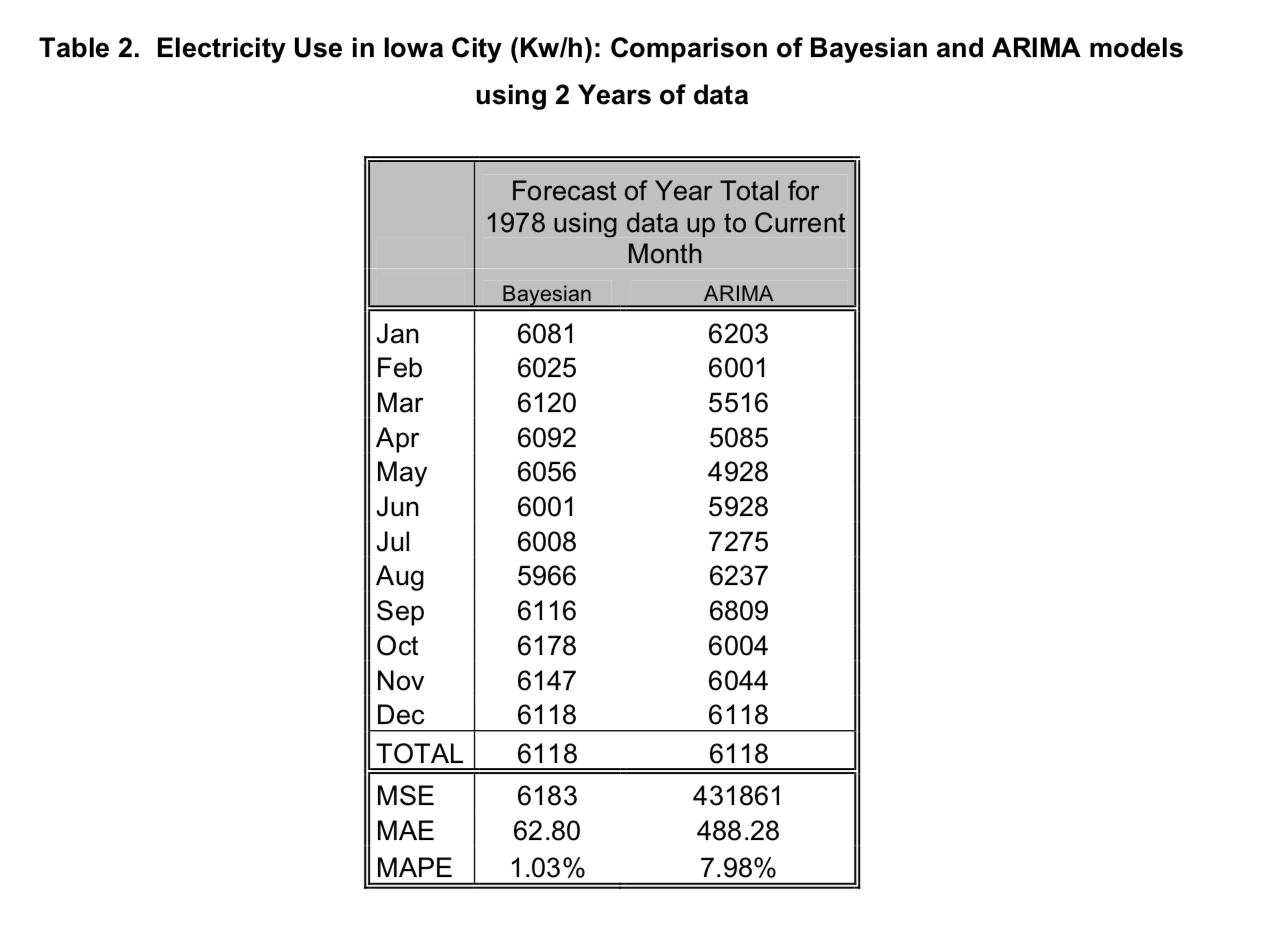

In [38]:
Image(filename='Bayesian_vs_ARIMA.png')

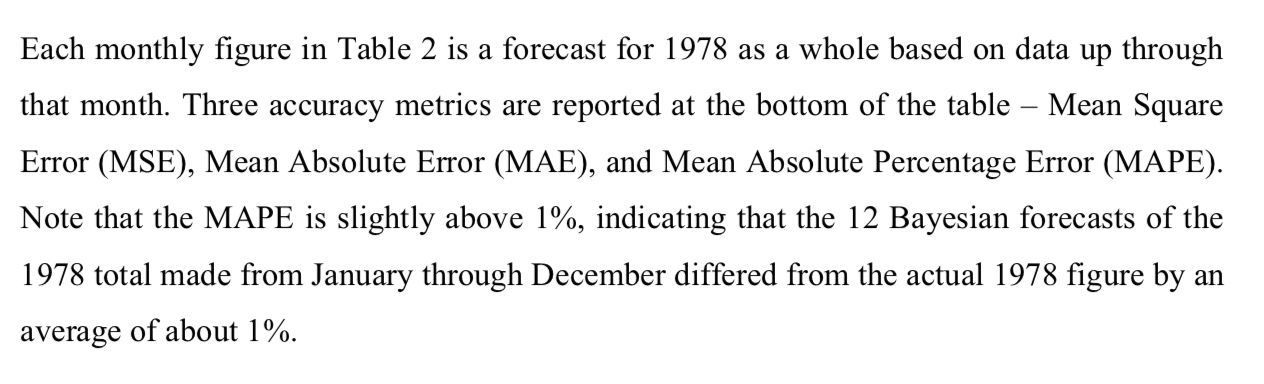

In [39]:
Image(filename='PIC2.png')

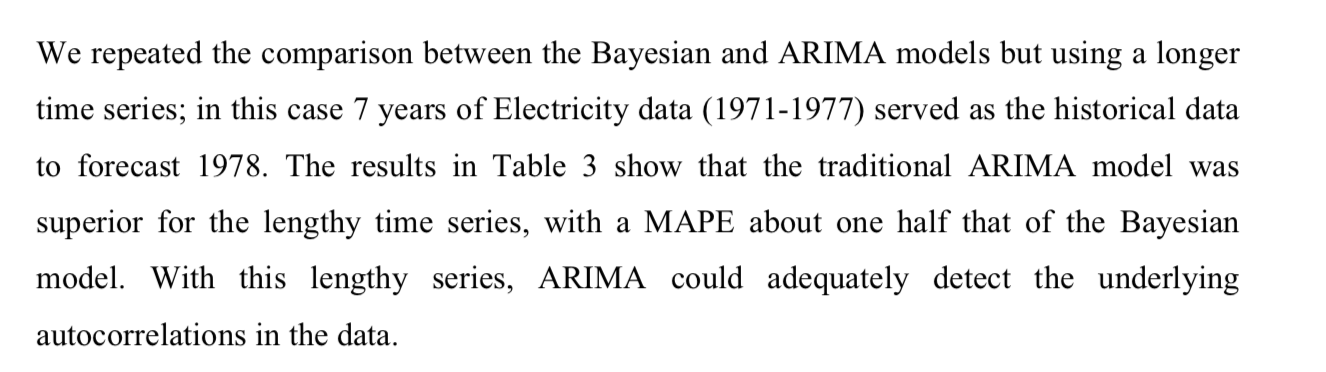

In [40]:
Image(filename='pic3.png')

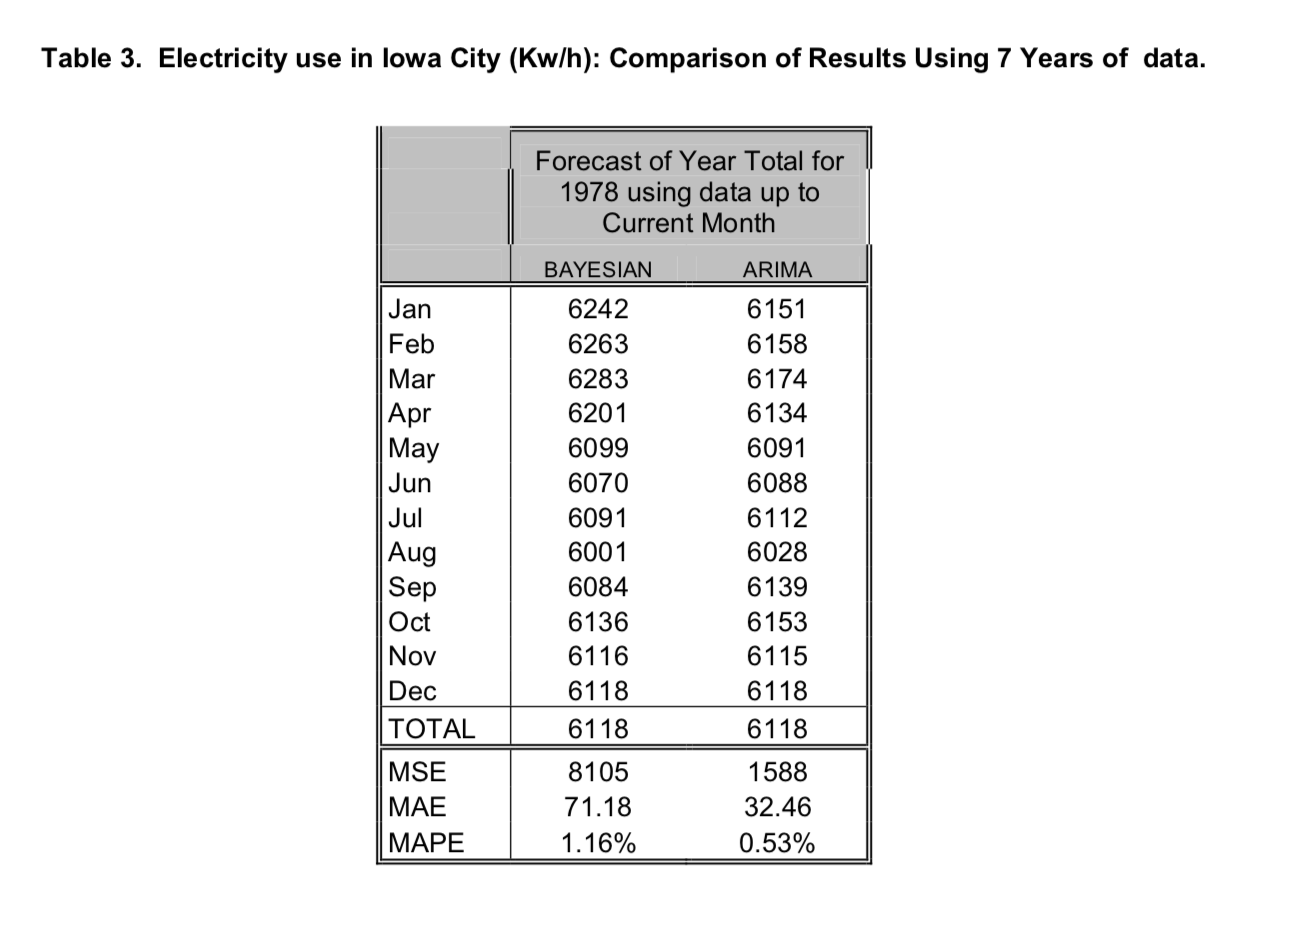

In [41]:
Image(filename='pic4.png')

As you can see above, the ARIMA model outperforms the Bayesian model when using 7 years of data.